In [3]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import wordcloud
import numpy as np
import seaborn as sns

In [4]:
# Import raw dataset from local files
raw_dataset = pd.read_csv("train.csv")
to_predict = pd.read_csv("test.csv")

# First overview of the data
raw_dataset.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


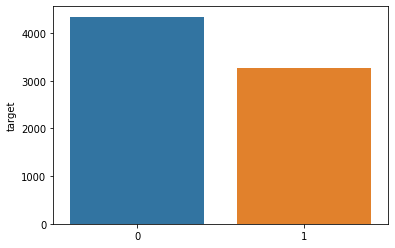

In [5]:
# Counting disaster and non disater tweets
balance=raw_dataset["target"].value_counts()
sns.barplot(balance.index,balance)

#### Note that even though the dataset has more non disaster tweets, it is still quite balanced since there are 43% of real disaser tweets.

# Preprocessing for NLP
#### First remove id and location because it has to many different values to be useful

In [6]:
# Keep only usable columns
df = raw_dataset[["keyword", "text", "target"]]
df_to_pred = to_predict[["keyword", "text"]]

df.head(5)

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


#### Let's lemmatize, remove common words and clean special characters

In [8]:
# Import Spacy and french initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

In [9]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
# Remove all non alphanumerical characters
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_to_pred["text_clean"] = df_to_pred["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# To lower case, remove useless whitespaces 
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_to_pred["text_clean"] = df_to_pred["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Lemmatize and remove stop words
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df_to_pred["text_clean"] = df_to_pred["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [11]:
# Save all lemmas with their multiplicity
lemmas = " ".join([text for text in df["text_clean"]])

#### Let's visualise what we have

In [12]:
# Small sample
df.head(5)

,keyword,text,target,text_clean
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


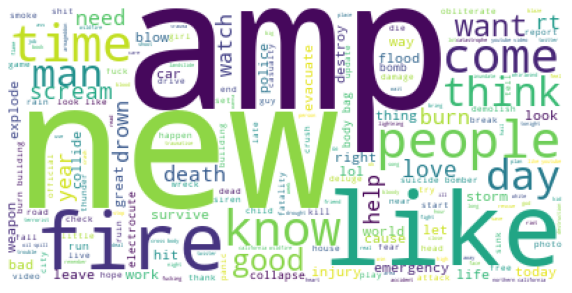

In [13]:
# Create a word cloud 
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color='steelblue', stopwords=STOP_WORDS)

# Generate wordcloud
cloud = wd.generate(lemmas)

# Visualize wordcloud 
plt.figure(figsize = (10, 10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

#### Some words are common in the corpus, lets remove them.

In [14]:
# Create a DataFrame of lemmatized token
lemmadf = pd.Series(lemmas.split(" "))

In [15]:
# Filtering lemmas with more than 100 occurences
common = lemmadf.value_counts() > 100
print(lemmadf.value_counts()[common])
common = common[common]

              4272
like           391
fire           354
amp            298
s              258
new            230
people         199
news           186
burn           175
video          173
kill           172
2              163
crash          161
come           160
bomb           158
emergency      157
disaster       153
attack         152
body           149
year           148
time           144
look           143
police         139
man            136
home           135
day            134
know           133
family         132
think          129
building       127
flood          126
good           126
love           124
storm          122
watch          117
california     117
suicide        117
train          116
want           115
collapse       115
world          115
work           113
life           112
car            111
scream         111
death          111
3              106
rt             105
cause          104
nuclear        101
need           101
dtype: int64


In [16]:
# Update stop words
STOP_WORDS_updated = STOP_WORDS.union(common.index)

# Remove new stop words
df["text_clean_updated"] = df["text_clean"].apply(lambda x: " ".join([lemma for lemma in x.split(" ") if lemma not in STOP_WORDS_updated]))
df_to_pred["text_clean_updated"] = df_to_pred["text_clean"].apply(lambda x: " ".join([lemma for lemma in x.split(" ") if lemma not in STOP_WORDS_updated]))

df.head(5)

,keyword,text,target,text_clean,text_clean_updated
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,deed reason earthquake allah forgive
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest near la ronge sask canada
2,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,resident ask shelter place notify officer evac...
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,13000 receive wildfire evacuation order
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,send photo ruby alaska smoke wildfire pour school


#### At this stage can we see differences between the two groups?

In [17]:
# Save all lemmas with their multiplicity
lemmas_0 = " ".join([text for text in df[df["target"] == 0]["text_clean"]])
lemmas_1 = " ".join([text for text in df[df["target"] == 1]["text_clean"]])

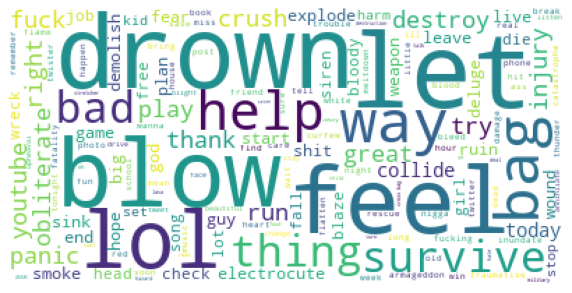

In [18]:
# Create a word cloud 
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color='steelblue', stopwords=STOP_WORDS_updated)

# Generate wordcloud
cloud = wd.generate(lemmas_0)

# Visualize wordcloud 
plt.figure(figsize = (10, 10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

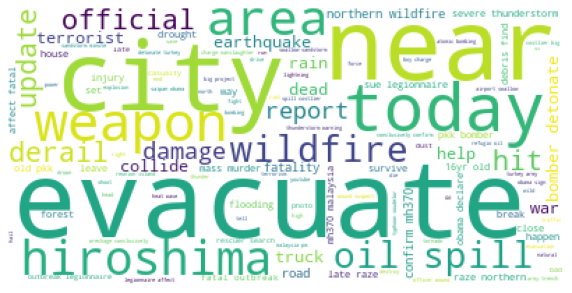

In [19]:
# Create a word cloud 
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color='steelblue', stopwords=STOP_WORDS_updated)

# Generate wordcloud
cloud = wd.generate(lemmas_1)

# Visualize wordcloud 
plt.figure(figsize = (10, 10))
plt.imshow(cloud)
plt.axis("off")
plt.show()

#### At this stage it seems that "LOL" is typicaly found in non disater tweets, "Evacuate" is typical of disaster tweets. 

# Encoding data
Let's dive further in the process and prepare data to train a Deep Learning algorithm.

In [20]:
# visualise empty cleaned tweets
display(df[df["text_clean_updated"] == ""])

# delete lines with empty cleaned tweets
df = df[df["text_clean_updated"] != ""]
# do not do it for df_to_pred since we need to predict every line 

,keyword,text,target,text_clean,text_clean_updated
15,NaN,What's up man?,0,s man,
1322,burning,Why put out a fire that's still burning?,0,fire s burn,
3741,fire,Why put out a fire when it's still burning.,0,fire burn,
3749,fire,I See Fire,0,fire,
6015,screams,* Screams *,0,scream,
6277,storm,this storm????,0,storm,
6372,suicide%20bomb,she's a suicide bomb,0,s suicide bomb,


#### Only a few tweets were lost with our preprocessing.

In [21]:
# We keep only the 1000 most frequent words, this may create new empty tweets
# Use keras tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df["text_clean_updated"])

# Create tokenized tweets
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean_updated)
df_to_pred["text_encoded"] = tokenizer.texts_to_sequences(df_to_pred.text_clean_updated)

# Add new column with lenght of token list
df["len"] = df["text_encoded"].apply(lambda x: len(x))
df_to_pred["len"] = df_to_pred["text_encoded"].apply(lambda x: len(x))

# Visualize empty tweets
display(df[df["len"] == 0])

,keyword,text,target,text_clean,text_clean_updated,text_encoded,len
7,NaN,I'm on top of the hill and I can see a fire in...,1,hill fire wood,hill wood,[],0
16,NaN,I love fruits,0,love fruit,fruit,[],0
19,NaN,What a goooooooaaaaaal!!!!!!,0,goooooooaaaaaal,goooooooaaaaaal,[],0
20,NaN,this is ridiculous....,0,ridiculous,ridiculous,[],0
22,NaN,Love skiing,0,love skiing,skiing,[],0
...,...,...,...,...,...,...,...
6975,tsunami,All of this energy,0,energy,energy,[],0
6993,twister,This is my jam: Riser by Dierks Bentley @1061T...,0,jam riser dierks bentley 1061thetwister ihea...,jam riser dierks bentley 1061thetwister iheart...,[],0
7013,twister,@TheBuffShow @TheTwisterOkc My boyfriend wants...,0,thebuffshow thetwisterokc boyfriend want shani...,thebuffshow thetwisterokc boyfriend shaniatwai...,[],0
7334,wildfire,Be ember aware! http://t.co/LZmL1xB2nH,1,ember aware httptcolzml1xb2nh,ember aware httptcolzml1xb2nh,[],0


In [22]:
# delete lines with empty cleaned tweets
df = df[df["len"] != 0]
# not for df_to_pred
df.head(5)

,keyword,text,target,text_clean,text_clean_updated,text_encoded,len
0,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,deed reason earthquake allah forgive,"[360, 117]",2
1,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest near la ronge sask canada,"[62, 106, 454, 905]",4
2,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,resident ask shelter place notify officer evac...,"[392, 268, 238, 132, 268, 239, 326]",7
3,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,13000 receive wildfire evacuation order,"[18, 132, 239]",3
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,send photo ruby alaska smoke wildfire pour school,"[125, 67, 118, 18, 53]",5


#### All sentences must be of same length, so we use padding

In [23]:
# The padding lenght must be the same for train data and to_pred data
max_len = max(df["len"].max(), df_to_pred["len"].max())

# Padding token lists to same lenght
tweets_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post", maxlen=max_len)
tweets_pad_to_pred = tf.keras.preprocessing.sequence.pad_sequences(df_to_pred.text_encoded, padding="post", maxlen=max_len)

#### Train test split

In [24]:
# Train Test Split 70/ 30
TAKE_SIZE = int(0.70 * df.shape[0])

train_data = tf.data.Dataset.from_tensor_slices((tweets_pad, df.target.values)).take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = tf.data.Dataset.from_tensor_slices((tweets_pad, df.target.values)).skip(TAKE_SIZE)
test_data = test_data.batch(64)

# Data to pred
pred_data = tf.data.Dataset.from_tensor_slices(tweets_pad_to_pred)
pred_data = pred_data.batch(64)

In [25]:
# Visualize what we are doing
for text in test_data.take(1):
  print(text)

(<tf.Tensor: shape=(64, 15), dtype=int32, numpy=
array([[268, 359, 619,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359, 848,  61, 679, 190, 121,  67,   0,   0,   0,   0,   0,   0,
          0,   0],
       [874, 359, 751, 683,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [842, 268, 359,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [706, 501, 359,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [273,  55,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359, 848,  61, 679, 190, 121,  67,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359, 240,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359, 848,  61, 679, 190, 121,  67,   0,   0,   0,   0,   0,   0,
          0,   0],
       [359, 848,  61, 679, 190

# Create models

## Simple RNN
This is a classification model with binary target. Let's first create a sequential neural network with simple RNN layers.

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Visualise number of words in our disctionnary
tokenizer.num_words

1000

In [27]:
vocab_size = tokenizer.num_words # number of words in our disctionnary
squence_max_len = tweets_pad.shape[1] # length of a padded sequence
embedding_dim=64 # the dimensionality of the representation space

# Create sequential model
model = Sequential([
  Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(squence_max_len,), name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            64064     
                                                                 
 simple_rnn (SimpleRNN)      (None, 15, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 76,097
Trainable params: 76,097
Non-traina

#### Define optimizer and loss function
We use Binary Crossentropy that corresponds to our binary classification problem

In [28]:
# Binary classifier model with adam optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(), # Used for binary classification
              metrics=[tf.keras.metrics.BinaryAccuracy()])

#### Train model

In [29]:
# Training over 20 epochs
model.fit(train_data,
                    epochs=20, 
                    validation_data=test_data)

Epoch 1/20
82/82 [==============================] - 3s 13ms/step - loss: 0.5944 - binary_accuracy: 0.6820 - val_loss: 0.5943 - val_binary_accuracy: 0.6745
Epoch 2/20
82/82 [==============================] - 1s 9ms/step - loss: 0.4506 - binary_accuracy: 0.8013 - val_loss: 0.6709 - val_binary_accuracy: 0.6358
Epoch 3/20
82/82 [==============================] - 1s 9ms/step - loss: 0.3806 - binary_accuracy: 0.8420 - val_loss: 0.6506 - val_binary_accuracy: 0.6668
Epoch 4/20
82/82 [==============================] - 1s 9ms/step - loss: 0.3259 - binary_accuracy: 0.8693 - val_loss: 0.6951 - val_binary_accuracy: 0.6583
Epoch 5/20
82/82 [==============================] - 1s 9ms/step - loss: 0.2986 - binary_accuracy: 0.8821 - val_loss: 0.8042 - val_binary_accuracy: 0.6569
Epoch 6/20
82/82 [==============================] - 1s 9ms/step - loss: 0.2644 - binary_accuracy: 0.8967 - val_loss: 0.7652 - val_binary_accuracy: 0.6592
Epoch 7/20
82/82 [==============================] - 1s 10ms/step - loss: 0.

In [30]:
# Save model to file
model.save("model_simpleRNN.h5")

In [31]:
import plotly.graph_objects as go

# Tracing modl loss and vall loss over its training
simpleRNN_history = model.history.history
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

#### Val loss begins to grow immediatly, which means the model is overfitting from the first epoch: it fails to generalize.

# LSTM

In [32]:
from tensorflow.keras.layers import LSTM

# Same steps but with LSTM layers
model_LSTM = Sequential([
  Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(squence_max_len,), name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  LSTM(units=64, return_sequences=True), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

display(model_LSTM.summary())

# Same compilation and training
model_LSTM.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model_LSTM.fit(train_data,
                    epochs=20, 
                    validation_data=test_data)

# Save model_LSTM
model_LSTM.save("model_LSTM.h5")

# Trace loss and vall loss
LSTM_history = model_LSTM.history.history
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            64064     
                                                                 
 lstm (LSTM)                 (None, 15, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 110,177
Trainable params: 110,177
Non-tr

None

Epoch 1/20
82/82 [==============================] - 5s 28ms/step - loss: 0.6406 - binary_accuracy: 0.6175 - val_loss: 0.6045 - val_binary_accuracy: 0.7041
Epoch 2/20
82/82 [==============================] - 2s 19ms/step - loss: 0.4722 - binary_accuracy: 0.7913 - val_loss: 0.5796 - val_binary_accuracy: 0.7190
Epoch 3/20
82/82 [==============================] - 2s 20ms/step - loss: 0.4193 - binary_accuracy: 0.8241 - val_loss: 0.5986 - val_binary_accuracy: 0.6978
Epoch 4/20
82/82 [==============================] - 2s 20ms/step - loss: 0.4025 - binary_accuracy: 0.8293 - val_loss: 0.5854 - val_binary_accuracy: 0.6983
Epoch 5/20
82/82 [==============================] - 2s 19ms/step - loss: 0.3874 - binary_accuracy: 0.8454 - val_loss: 0.6312 - val_binary_accuracy: 0.6772
Epoch 6/20
82/82 [==============================] - 2s 20ms/step - loss: 0.3838 - binary_accuracy: 0.8464 - val_loss: 0.6749 - val_binary_accuracy: 0.6830
Epoch 7/20
82/82 [==============================] - 2s 20ms/step - los

#### Still a mitigated result



## GRU

In [33]:
from tensorflow.keras.layers import GRU

# Same steps but with GRU layers
model_GRU = Sequential([
  Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(squence_max_len,), name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

display(model_GRU.summary())

# Same compilation and training
model_GRU.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model_GRU.fit(train_data,
                    epochs=20, 
                    validation_data=test_data)

# Save model_GRU
model_GRU.save("model_GRU.h5")

# Trace loss and vall loss
GRU_history = model_GRU.history.history
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            64064     
                                                                 
 gru (GRU)                   (None, 15, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 99,105
Trainable params: 99,105
Non-trai

None

Epoch 1/20
82/82 [==============================] - 5s 27ms/step - loss: 0.6766 - binary_accuracy: 0.5720 - val_loss: 0.6267 - val_binary_accuracy: 0.6821
Epoch 2/20
82/82 [==============================] - 2s 19ms/step - loss: 0.4821 - binary_accuracy: 0.7865 - val_loss: 0.5412 - val_binary_accuracy: 0.7275
Epoch 3/20
82/82 [==============================] - 2s 19ms/step - loss: 0.4222 - binary_accuracy: 0.8190 - val_loss: 0.5695 - val_binary_accuracy: 0.7005
Epoch 4/20
82/82 [==============================] - 2s 19ms/step - loss: 0.3995 - binary_accuracy: 0.8302 - val_loss: 0.6357 - val_binary_accuracy: 0.6763
Epoch 5/20
82/82 [==============================] - 2s 19ms/step - loss: 0.3924 - binary_accuracy: 0.8372 - val_loss: 0.7770 - val_binary_accuracy: 0.6686
Epoch 6/20
82/82 [==============================] - 1s 18ms/step - loss: 0.3800 - binary_accuracy: 0.8441 - val_loss: 0.6291 - val_binary_accuracy: 0.6938
Epoch 7/20
82/82 [==============================] - 2s 19ms/step - los

#### Still overfitting


## Predictions
Create prediction file to sumbit to kaggle

In [34]:
# Training the LSTM model again with 2 epochs because it had 
# the best accuracy accross models, best val_loss accros LSTM epochs

model_LSTM = Sequential([
  Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(squence_max_len,), name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  LSTM(units=64, return_sequences=True), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(8, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

display(model_LSTM.summary())

# Same compilation and training
model_LSTM.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model_LSTM.fit(train_data,
                    epochs=2, 
                    validation_data=test_data)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            64064     
                                                                 
 lstm_2 (LSTM)               (None, 15, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 110,177
Trainable params: 110,177
Non-tr

None

Epoch 1/2
82/82 [==============================] - 5s 28ms/step - loss: 0.6252 - binary_accuracy: 0.6475 - val_loss: 0.5648 - val_binary_accuracy: 0.7199
Epoch 2/2
82/82 [==============================] - 2s 19ms/step - loss: 0.4623 - binary_accuracy: 0.7969 - val_loss: 0.5651 - val_binary_accuracy: 0.7248


In [35]:
# Predict on kaggle test set
to_submit = model.predict(pred_data)

# Transform probabilities into labels
to_submit[to_submit >= 0.5] = int(1)
to_submit[to_submit < 0.5] = int(0)

# Create submission file
pd.DataFrame(to_submit).to_csv('submission.csv', index=False, header=False)

## Conclusion
The best model we have is the one using LSTM, after 2 epochs. It reached the highest val_binary_accuracy of 0.72 which is descent, but the model quickly started to overfit. Here we created our neural network from scratch.

To improve the accuracy we could:
- try to simplify models, as our train set is limited
- use tansfert learning as a second approach, using pretrained BERT model (sentiment classification model). Pretrained models are good if we have a limited datasets.